**Importing libraries**

importing the important libraries that will be used in this code

In [11]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import math
import sys
import time
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score ,mean_squared_error , r2_score, mean_absolute_error

**Data Preprocessing**

we are here reading the data from the csv file and converting it into dataframe , scaling the data to get better output and balancing the class that will be predicted to make 'g' = to 'h'

In [12]:
df = pd.read_csv("./telescope_data/telescope_data.csv")
df = df.rename(columns={df.columns[0]: "index"})
g = df[df["class"] == "g"]
h = df[df["class"] == "h"]
g_new = g.sample(n=len(h))
data = pd.concat([g_new, h])
class_col = data["class"]
scaled_df = data.drop(columns=["class", "index"]).copy()

for col in scaled_df.select_dtypes(include="number").columns:
    col_min = scaled_df[col].min()
    col_max = scaled_df[col].max()
    rng = col_max - col_min
    scaled_df[col] = 0.0 if rng == 0 else (scaled_df[col] - col_min) / rng

data = scaled_df.copy()
data["class"] = class_col

**Divide the data and split**

 we divide the data and split it into training and validation and testing sets with calculated ratios

In [13]:
X = data.drop(columns=["class"])
y = data["class"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,  stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

**Distance claculator between two points**

This function cacluate the distance between the validation point and all the training points to return a dataframe with all the calculated distance according to ecludian rule

In [14]:
def distance_calc(val_point, train_df):
    val_features = np.array(val_point, dtype=float)
    train_features = train_df.to_numpy(dtype=float)

    distances = np.sqrt(np.sum((train_features - val_features) ** 2, axis=1))

    result_df = pd.DataFrame({
        'Index': train_df.index,
        'Distance': distances
    })
    return result_df

**Finding k-Nearest function**

This function returns the dataframe of the calculated distance sorted ascendingly to get the first k nearest points we want to get for the prediction

In [15]:
def k_nearest(df , k):
    return df.sort_values('Distance').head(k)

**Making predictions manual function**

This function return the predictions by taking the sorted dataframe and according to the k determined it counts the number of labels that has 'g' and the others with 'h' to predict according to the majority

In [16]:
def make_prediction(df , y_train):
    g_count = 0
    h_count = 0
    for i in range(df.shape[0]):
        neighbor_index = df.iloc[i]['Index']
        label = y_train.loc[neighbor_index]

        if label == 'g':
            g_count+=1
        else:
            h_count+=1
    if g_count >= h_count: #break ties with g
        return 'g'
    else:
        return 'h'

**Determine the best k value**

we test all the possible k values to get the best k according to the accuracy to use this k in the test to make the model better and get the best accuracy within the test and visualizing the k results in the following digram

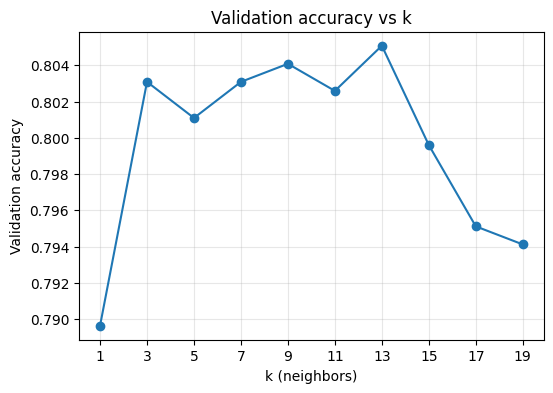

The best k value is: 13 with validation accuracy of 0.8050847457627118


In [17]:
#Validation accuracy
k_values = [1,3,5,7,9,11,13,15,17,19]
val_accuracies = []

for k in k_values:
    correct_pred = 0
    false_pred = 0
    for i in range(X_val.shape[0]):
        y_actual = y_val.iloc[i]
        x_val_point = X_val.iloc[i]
        distances = distance_calc(x_val_point,X_train)
        knn = k_nearest(distances,k)
        pred = make_prediction(knn , y_train)
        if y_actual == pred:
            correct_pred+=1
        else:
            false_pred+=1

    val_accuracies.append(correct_pred / (correct_pred + false_pred))

best_k = k_values[val_accuracies.index(max(val_accuracies))]
best_val_accuracy = max(val_accuracies)

# Plot validation accuracy vs k
plt.figure(figsize=(6,4))
plt.plot(k_values, val_accuracies, marker='o')
plt.xticks(k_values)
plt.xlabel('k (neighbors)')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs k')
plt.grid(True, alpha=0.3)
plt.show()
print("The best k value is:", best_k , "with validation accuracy of", best_val_accuracy)

**Testing the mdoel**

Here we use the functions we have done before to test the model and get the accuracy of this testing

In [18]:
#Test accuracy with best k value
manual_predictions = []
correct_pred = 0
false_pred = 0
for i in range(X_test.shape[0]):
    y_actual = y_test.iloc[i]
    x_test_point = X_test.iloc[i]
    distances = distance_calc(x_test_point,X_train)
    knn = k_nearest(distances,best_k)
    pred = make_prediction(knn , y_train)
    manual_predictions.append(pred)
    if y_actual == pred:
        correct_pred+=1
    else:
        false_pred+=1

print("accuracy of test =", correct_pred / (correct_pred + false_pred))


accuracy of test = 0.7932237169905332


**Auto Predictions**

here we use the sklearn library to train the model using the fit function and then test the mdoel using the predict function and we got the best k value to test the model as previous to have both output using the manual predictions and using the sklearn library

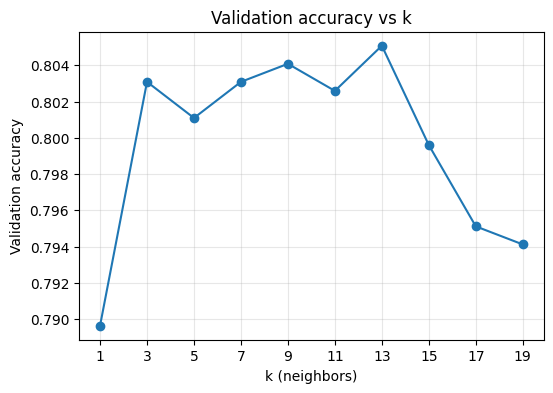

The best k value is: 13 with validation accuracy of 0.8050847457627118
Test acc: 0.7932237169905332 with k = 13


In [19]:
k_values_sk = [1,3,5,7,9,11,13,15,17,19]
val_accuracies_sk = []

for k in k_values_sk:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    val_pred = knn.predict(X_val)
    val_accuracies_sk.append(accuracy_score(y_val, val_pred))

# Plot validation accuracy vs k
plt.figure(figsize=(6,4))
plt.plot(k_values_sk, val_accuracies_sk, marker='o')
plt.xticks(k_values_sk)
plt.xlabel('k (neighbors)')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs k')
plt.grid(True, alpha=0.3)
plt.show()

print("The best k value is:", k_values_sk[val_accuracies_sk.index(max(val_accuracies_sk))] , "with validation accuracy of", max(val_accuracies_sk))
knn = KNeighborsClassifier(n_neighbors=k_values_sk[val_accuracies_sk.index(max(val_accuracies_sk))])
knn.fit(X_train,y_train)
sk_pred = knn.predict(X_test)

print("Test acc:", accuracy_score(y_test, sk_pred) , "with k =", k_values_sk[val_accuracies_sk.index(max(val_accuracies_sk))])


**Comparing between the models**

We will find that both the manual and the sklearn models are approximatly getting the same output regarding the best k and the accuracy and this is proofed in the next cell when calculating different metrics

In [20]:
pos = 'h'

print("Manual KNN:")
print("  precision =", precision_score(y_test, manual_predictions, pos_label=pos))
print("  recall    =", recall_score(y_test, manual_predictions, pos_label=pos))
print("  f1        =", f1_score(y_test, manual_predictions, pos_label=pos))
print("  confusion matrix:\n", confusion_matrix(y_test, manual_predictions, labels=['g','h']))

print("\nSklearn KNN:")
print("  precision =", precision_score(y_test, sk_pred, pos_label=pos))
print("  recall    =", recall_score(y_test, sk_pred, pos_label=pos))
print("  f1        =", f1_score(y_test, sk_pred, pos_label=pos))
print("  confusion matrix:\n", confusion_matrix(y_test, sk_pred, labels=['g','h']))

Manual KNN:
  precision = 0.8420441347270615
  recall    = 0.7221115537848606
  f1        = 0.7774798927613941
  confusion matrix:
 [[867 136]
 [279 725]]

Sklearn KNN:
  precision = 0.8420441347270615
  recall    = 0.7221115537848606
  f1        = 0.7774798927613941
  confusion matrix:
 [[867 136]
 [279 725]]


# Data Preprocessing

This section handles the loading and preprocessing of the California housing dataset. We implement proper data splitting to prevent data leakage, and we apply 2 ways of scaling a manual scaler and StandardScaler for feature normalization, and preserve the target variable in its original scale for interpretable results.


In [21]:
#Reading data and scaling features and splitting data
df = pd.read_csv('./California_Houses/California_Houses.csv')
#Dont scale the target variable
y = df["Median_House_Value"]

# # Costum scaling
# for col in df.select_dtypes(include="number").columns:
#     col_min = df[col].min()
#     col_max = df[col].max()
#     rng = col_max - col_min
#     df[col] = 0.0 if rng == 0 else (df[col] - col_min) / rng


X = df.drop(columns=["Median_House_Value"])

#Split data into training 70%, validation 15% and test 15%
X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.5)

# Fit scaler on TRAIN only (prevents data leakage) By library
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# Prediction functions

We made 2 general functions a manual which is used by any manual made model which takes an x array and the coffs and returns an array of the predictions , and another function which is used by the models from the sklearn libraries which take the model and the x array and predicts y and returns it

In [22]:
# Manual prediction function
def prediction_manual(X, w):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    y_predict = X_b.dot(w)
    return y_predict

# Sklearn prediction function
def prediction_sk(X, model):
    y_pred = model.predict(X)
    return y_pred

# MSE function

We made a manual function that calculates the mse of any model manual or sklearn

In [23]:
# Mean squared error function manual
#MSE = (y_pred - y_actual)^2 / n
def MSE_function(y_pred, y_actual):
    MSE = y_pred - y_actual
    MSE = MSE ** 2
    MSE = MSE.sum() / MSE.size
    return MSE

# Linear regression from scratch (Manual)

We applied the standard equation  *w = (X^T X)^(-1) X^T y* in this function and make it return an array of the calculated coeffs used in the prediction functions

In [24]:
# Linear regression manual implementation
# W = (X^T X)^(-1) ( X^T y )
def linear_regression_manual(X_train, y_train):
    X = X_train.astype(float)
    y = y_train.astype(float)
    X_b = np.c_[np.ones((X.shape[0], 1), dtype=float), X]
    w = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return w

# Linear regression using scikit learn libraries

We used the LinearRegression model from sklearn library, and trained it using the .fit method and tested the model by the validation set and then returned the model at the end to use it in the prediction function

In [25]:
# Linear regression scikit implementation
def linear_regression_sk(X_train, y_train , X_val, y_val):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_val)
    mse = MSE_function(y_pred, y_val)
    print(f"Sklearn Linear Regression Validation MSE: {mse:.6f}")
    return lin_reg

# Linear regression using gradient descent implementation

We applied *w = w - lr * (2/n) * X^T (Xw - y)* as the model equation and tested multiaple learning rates to get the best one (optimization) , it returns the best learning rate with its equivelent coeffs


In [26]:
# Manual linear regression gradient decent implementation with learning rate optimization
def linear_regression_gd(X_train, y_train, X_val, y_val):
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    itreations = 7000
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    X_val = X_val.astype(float)
    y_val = y_val.astype(float)

    # Add bias term
    X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]

    best_lr = None
    best_w = None
    best_mse = float("inf")

    mse_values = []

    # Loop through different learning rates
    for lr in learning_rates:
        w = np.zeros(X_b.shape[1])

        for _ in range(itreations):
            gradients = (2 / len(X_b)) * X_b.T.dot(X_b.dot(w) - y_train)
            w -= lr * gradients

        y_pred = X_val_b.dot(w)
        mse = MSE_function(y_pred, y_val)
        mse_values.append(mse)
        print(f"Learning rate={lr}, Validation MSE={mse}")

        if mse < best_mse:
            best_mse = mse
            best_lr = lr
            best_w = w

    plt.figure(figsize=(8, 5))
    plt.plot(learning_rates, mse_values, marker='o', linestyle='-', linewidth=2)
    plt.title("Learning Rate Optimization", fontsize=14)
    plt.xlabel("Learning Rate", fontsize=12)
    plt.ylabel("Validation MSE", fontsize=12)
    plt.xscale('log')  # show LR on log scale for clarity
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return best_lr, best_w

# Ridge manual implementation

We implemented *w = (X^T X + alpha * I)^(-1) X^T y* as the model equation, we also looped throuh values of alphas to find the one with the least mse (optimization) , it returns the best alpha and the best w to be used in the prediction functions

In [27]:
# Ridge regularization with manual implementation and optimization
def ridge_manual(X_train, y_train , X_val , y_val):
   #List of alphas to try
   alphas = [0.001, 0.01, 0.1, 1, 10, 100]
   ridge_mse = []
   weights = []

   #Convert to float
   X = X_train.astype(float)
   y = y_train.astype(float)
   X_val_float = X_val.astype(float)
   y_val_float = y_val.astype(float)

   #Add bias term
   X_b = np.c_[np.ones((X.shape[0], 1)), X]
   X_val_b = np.c_[np.ones((X_val_float.shape[0], 1)), X_val_float]

   for alpha in alphas:
      I = np.eye(X_b.shape[1])
      I[0, 0] = 0
      w = np.linalg.inv(X_b.T @ X_b + alpha * I) @ X_b.T @ y
      y_predict = X_val_b.dot(w)
      ridge_mse.append(MSE_function(y_predict, y_val_float))
      weights.append(w)

   best_index = np.argmin(ridge_mse)
   best_alpha = alphas[best_index]
   best_w = weights[best_index]

   plt.figure(figsize=(8, 5))
   plt.plot(alphas, ridge_mse, marker='o', linestyle='-', linewidth=2)
   plt.xscale('log')  # Regularization strength works best on log scale
   plt.title("Ridge Regularization Optimization", fontsize=14)
   plt.xlabel("Alpha (Regularization Strength)", fontsize=12)
   plt.ylabel("Validation MSE", fontsize=12)
   plt.grid(True, linestyle='--', alpha=0.6)
   plt.scatter(best_alpha, ridge_mse[best_index], color='red', s=100, label=f"Best α = {best_alpha}")
   plt.legend()
   plt.show()

   return best_alpha , best_w

# Ridge regression using scikit learn libraries

We used the Ridge model from sklearn library, and trained it using the .fit method , where we also implemented the alpha optimization to get the best results and tested the model by the validation set and then returned the model at the end to use it in the prediction function

In [28]:
def ridge_sk(X_train, y_train, X_val, y_val):
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]
    ridge_mse = []
    ridge_weights = []

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_val)
        mse = mean_squared_error(y_val, y_pred_ridge)
        ridge_mse.append(mse)
        ridge_weights.append(ridge.coef_)
        print(f"Alpha={alpha}, MSE={mse}")

    best_index = ridge_mse.index(min(ridge_mse))
    best_alpha = alphas[best_index]
    best_w = ridge_weights[best_index]

    #train final model with best alpha
    best_ridge = Ridge(alpha=best_alpha)
    best_ridge.fit(X_train, y_train)

    y_pred = best_ridge.predict(X_val)
    mse = MSE_function(y_pred, y_val)
    print(f"Sklearn Ridge Regression Validation MSE: {mse:.6f}")

    return best_ridge

# Ridge Regression using Gradient Descent

We used **Ridge Regression** using **Gradient Descent** and it automatically searches for the best combination of **learning rate (η)** and **regularization strength (α)** based on validation error.

## Ridge Cost Function

$$J(\mathbf{w}) = \frac{1}{2m} \sum_{i=1}^{m} (h_\mathbf{w}(x^{(i)}) - y^{(i)})^2 + \frac{\alpha}{2m} \sum_{j=1}^{n} w_j^2$$

## Gradient Descent Update Rule

$$w_j := w_j - \eta \left[ \frac{1}{m} \sum_{i=1}^{m} (h_\mathbf{w}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\alpha}{m}w_j \right]$$

For the bias term $w_0$:

$$w_0 := w_0 - \eta \left[ \frac{1}{m} \sum_{i=1}^{m} (h_\mathbf{w}(x^{(i)}) - y^{(i)}) \right]$$

**Parameters:**
- $\eta$: learning rate  
- $\alpha$: regularization strength


In [29]:
#Ridge gradient decent implementation with learning rate and alpha optimization
def ridge_gradient_descent(X_train, y_train, X_val, y_val):
    # Alphas and learning rate values to try
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    iterations = 10000

    # Add bias term
    X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
    m, n = X_b.shape

    best_alpha = None
    best_lr = None
    best_w = None
    best_mse = float('inf')

    lr_mse = []      # Best MSE for each learning rate
    alpha_mse = []   # Best MSE for each alpha overall
    alpha_all_mse = {a: [] for a in alphas}  # For tracking alpha per LR

    for lr in learning_rates:
        best_mse_for_lr = float('inf')
        for alpha in alphas:
            w = np.zeros(n)

            for i in range(iterations):
                y_pred = X_b.dot(w)
                error = y_pred - y_train

                # Gradients
                dw = (1/m) * (X_b.T.dot(error)) + (alpha/m) * w
                dw[0] = (1/m) * X_b.T.dot(error)[0]
                w -= lr * dw

            # Validation prediction
            y_val_pred = X_val_b.dot(w)
            mse = MSE_function(y_val, y_val_pred)

            alpha_all_mse[alpha].append(mse)  # store all for later averaging

            # Track best for this LR
            if mse < best_mse_for_lr:
                best_mse_for_lr = mse

            # Check for best combination
            if mse < best_mse:
                best_mse = mse
                best_alpha = alpha
                best_lr = lr
                best_w = w.copy()

        lr_mse.append(best_mse_for_lr)

    # Compute mean MSE across learning rates for each alpha
    for alpha in alphas:
        alpha_mse.append(np.mean(alpha_all_mse[alpha]))


    plt.figure(figsize=(12,5))

    # 1️. Learning Rate Optimization
    plt.subplot(1,2,1)
    plt.plot(learning_rates, lr_mse, marker='o', linewidth=2)
    plt.xscale('log')
    plt.title("Learning Rate Optimization", fontsize=13)
    plt.xlabel("Learning Rate")
    plt.ylabel("Best Validation MSE")
    plt.grid(True, linestyle='--', alpha=0.6)

    # 2️. Alpha Optimization
    plt.subplot(1,2,2)
    plt.plot(alphas, alpha_mse, marker='o', color='orange', linewidth=2)
    plt.xscale('log')
    plt.title("Alpha (Regularization Strength) Optimization", fontsize=13)
    plt.xlabel("Alpha")
    plt.ylabel("Average Validation MSE")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    return best_lr, best_alpha, best_w

# Lasso regression using scikit learn libraries

We implemented the Lasso model from sklearn library with alot of alphas and looped through them calculating the mse each time and at the end choosing the best scorring alpha , and then returning the final model trained on the training data with that alpha to use in the predition functions

In [30]:
# Lasso regression and alpha optimization with sklearn libraries
def lasso_sk(X_train, y_train , X_val , y_val):
    #List of alphas to try
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]
    mse_scores = []

    for alpha in alphas:
        # Create and train the Lasso model
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_train, y_train)

        # Predict on validation set
        y_pred = lasso.predict(X_val)

        # Compute MSE
        mse = MSE_function(y_pred, y_val)
        mse_scores.append(mse)

    # Find best alpha
    best_index = mse_scores.index(min(mse_scores))
    best_alpha = alphas[best_index]

    #train final model with best alpha
    best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
    best_lasso.fit(X_train, y_train)

    y_pred = best_lasso.predict(X_val)
    mse = MSE_function(y_pred, y_val)
    print(f"Sklearn Lasso Regression Validation MSE: {mse:.6f}")

    return best_lasso

# Lasso regression with sklearn prediction function
def prediction_lasso_sk(X, lasso_reg):
    y_pred = lasso_reg.predict(X)
    return y_pred

# Model Comparison

This cell is made to run the function , train , validate and test each one of the functions we made calculating the MSE and R2 score from each model prediction to the test set and timing it and printing the results in a fromal and describable way.

CALIFORNIA HOUSING PRICE PREDICTION - MODEL COMPARISON
Dataset: California Housing Prices
Features: 13 numerical features
Target: Median House Value (not scaled)
Split: 70% Train, 15% Validation, 15% Test

 STARTING MODEL TRAINING AND EVALUATION...
------------------------------------------------------------

1️ MANUAL LINEAR REGRESSION
----------------------------------------
 Model trained successfully
 Weights shape: (14,)
 First 5 weights: [207274.99204042  74269.46932935  11787.10916472 -13773.64305544
  44578.893648  ]
 VALIDATION RESULTS:
  MSE: 4895911977.300933
  MAE: 118336.916343
  R²:  0.626831
 TEST RESULTS:
   MSE: 4586375859.992009
   MAE: 49720.968835
   R²:  0.658717
  Time: 0.02s

2️. SCIKIT-LEARN LINEAR REGRESSION
----------------------------------------
Sklearn Linear Regression Validation MSE: 4895911977.300929
 TEST RESULTS:
   MSE: 4586375859.992006
   MAE: 49720.968835
   R²:  0.658717
⏱  Time: 0.06s

3️3. MANUAL RIDGE REGRESSION
--------------------------------

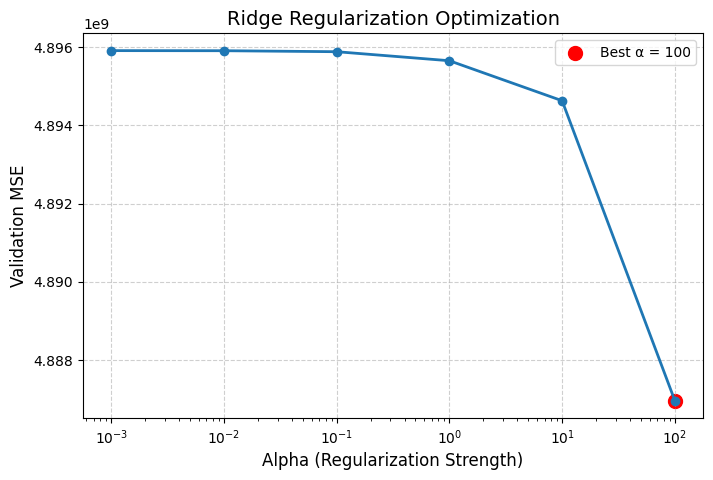

 Best alpha: 100
 TEST RESULTS:
   MSE: 4615695521.906221
   MAE: 50100.751412
   R²:  0.656535
 Time: 1.35s

4️. SCIKIT-LEARN RIDGE REGRESSION
----------------------------------------
Alpha=0.001, MSE=4895911693.738093
Alpha=0.01, MSE=4895909144.048398
Alpha=0.1, MSE=4895883880.926762
Alpha=1, MSE=4895653259.358299
Alpha=10, MSE=4894630020.090881
Alpha=100, MSE=4886959967.28933
Sklearn Ridge Regression Validation MSE: 4886959967.289330
 TEST RESULTS:
   MSE: 4615695521.906223
   MAE: 50100.751412
   R²:  0.656535
  Time: 0.08s

5️. MANUAL GRADIENT DESCENT
----------------------------------------
Learning rate=0.0001, Validation MSE=7791728259.362214


Learning rate=0.001, Validation MSE=4904753487.819439
Learning rate=0.01, Validation MSE=4918631922.801203
Learning rate=0.1, Validation MSE=4896166820.263345


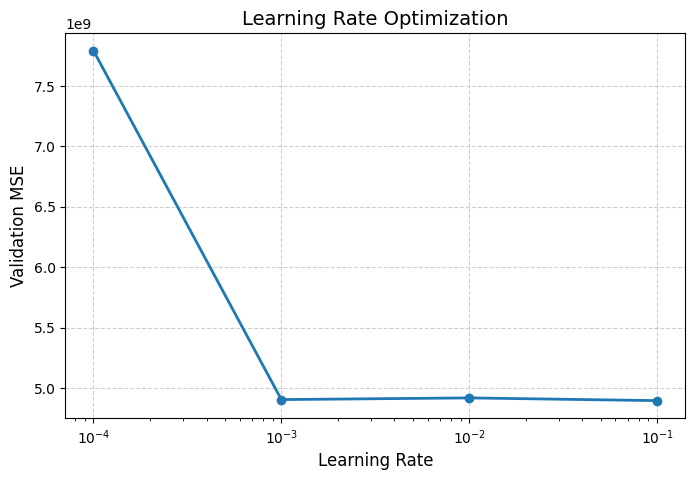

 Best learning rate: 0.1
 TEST RESULTS:
   MSE: 4586130754.821426
   MAE: 49726.362115
   R²:  0.658735
  Time: 11.54s

6️. RIDGE GRADIENT DESCENT
----------------------------------------


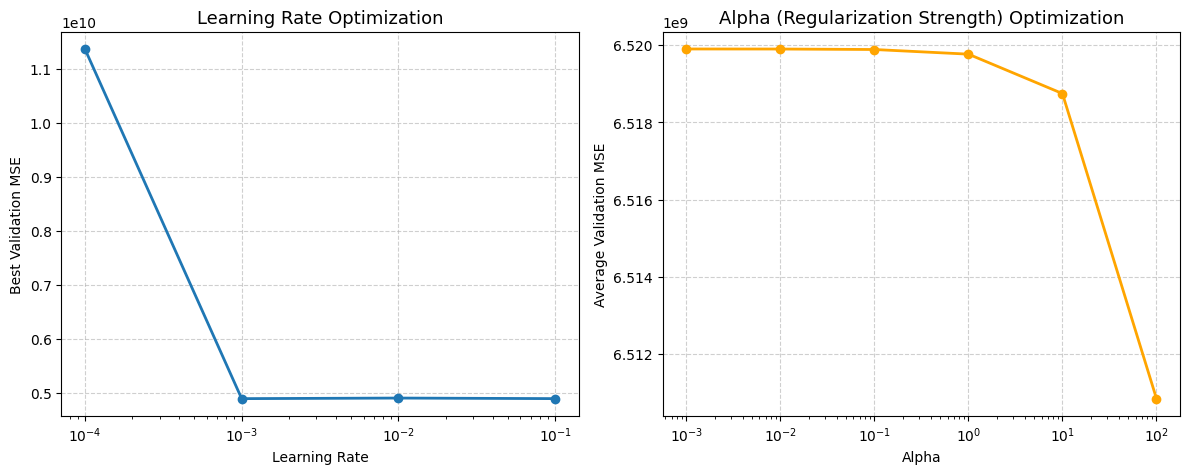

 Best learning rate: 0.001
 Best alpha: 100
 TEST RESULTS:
   MSE: 4778856860.536586
   MAE: 51316.195152
   R²:  0.644394
⏱  Time: 146.81s

7️. SCIKIT-LEARN LASSO REGRESSION
----------------------------------------
Sklearn Lasso Regression Validation MSE: 4894518043.211996
 TEST RESULTS:
   MSE: 4586029308.185246
   MAE: 49728.771657
   R²:  0.658743
  Time: 117.01s

COMPREHENSIVE RESULTS SUMMARY

 RANKED BY R² SCORE (Higher is Better):
------------------------------------------------------------
 1. Sklearn Lasso             | MSE: 4586029308.185246 | MAE: 49728.771657 | R²: 0.6587
 2. Gradient Descent          | MSE: 4586130754.821426 | MAE: 49726.362115 | R²: 0.6587
 3. Sklearn Linear            | MSE: 4586375859.992006 | MAE: 49720.968835 | R²: 0.6587
 4. Manual Linear             | MSE: 4586375859.992009 | MAE: 49720.968835 | R²: 0.6587
 5. Manual Ridge              | MSE: 4615695521.906221 | MAE: 50100.751412 | R²: 0.6565
 6. Sklearn Ridge             | MSE: 4615695521.906223 | 

In [31]:
print("=" * 80)
print("CALIFORNIA HOUSING PRICE PREDICTION - MODEL COMPARISON")
print("=" * 80)
print("Dataset: California Housing Prices")
print("Features: 13 numerical features")
print("Target: Median House Value (not scaled)")
print("Split: 70% Train, 15% Validation, 15% Test")
print("=" * 80)

# Initialize results storage
results = {}
test_mse_scores = {}
test_mae_scores = {}
test_r2_scores = {}

print("\n STARTING MODEL TRAINING AND EVALUATION...")
print("-" * 60)

# 1. MANUAL LINEAR REGRESSION

print("\n1️ MANUAL LINEAR REGRESSION")
print("-" * 40)
start_time = time.time()

# Train model
w_manual = linear_regression_manual(X_train, y_train)
print(f" Model trained successfully")
print(f" Weights shape: {w_manual.shape}")
print(f" First 5 weights: {w_manual[:5]}")

# Validation performance
y_val_pred_manual = prediction_manual(X_val, w_manual)
val_mse_manual = MSE_function(y_val_pred_manual, y_val)
val_mae_manual = mean_absolute_error(y_test , y_val_pred_manual)
val_r2_manual = r2_score(y_val, y_val_pred_manual)

print(f" VALIDATION RESULTS:")
print(f"  MSE: {val_mse_manual:.6f}")
print(f"  MAE: {val_mae_manual:.6f}")
print(f"  R²:  {val_r2_manual:.6f}")

# Test performance
y_test_pred_manual = prediction_manual(X_test, w_manual)
test_mse_manual = MSE_function(y_test_pred_manual, y_test)
test_mae_manual = mean_absolute_error(y_test , y_test_pred_manual)
test_r2_manual = r2_score(y_test, y_test_pred_manual)

test_mse_scores["Manual Linear"] = test_mse_manual
test_mae_scores["Manual Linear"] = test_mae_manual
test_r2_scores["Manual Linear"] = test_r2_manual

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_manual:.6f}")
print(f"   MAE: {test_mae_manual:.6f}")
print(f"   R²:  {test_r2_manual:.6f}")
print(f"  Time: {time.time() - start_time:.2f}s")

# 2. SCIKIT-LEARN LINEAR REGRESSION

print("\n2️. SCIKIT-LEARN LINEAR REGRESSION")
print("-" * 40)
start_time = time.time()

# Train model
sk_linear = linear_regression_sk(X_train, y_train, X_val, y_val)

# Test performance
y_test_pred_sk = prediction_sk(X_test, sk_linear)
test_mse_sk = MSE_function(y_test_pred_sk, y_test)
test_mae_sk = mean_absolute_error(y_test , y_test_pred_sk)
test_r2_sk = r2_score(y_test, y_test_pred_sk)

test_mse_scores["Sklearn Linear"] = test_mse_sk
test_mae_scores["Sklearn Linear"] = test_mae_sk
test_r2_scores["Sklearn Linear"] = test_r2_sk

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_sk:.6f}")
print(f"   MAE: {test_mae_sk:.6f}")
print(f"   R²:  {test_r2_sk:.6f}")
print(f"⏱  Time: {time.time() - start_time:.2f}s")


# 3. MANUAL RIDGE REGRESSION
print("\n3️3. MANUAL RIDGE REGRESSION")
print("-" * 40)
start_time = time.time()

# Train model with hyperparameter optimization
best_alpha_ridge, best_w_ridge = ridge_manual(X_train, y_train, X_val, y_val)
print(f" Best alpha: {best_alpha_ridge}")

# Test performance
y_test_pred_ridge_manual = prediction_manual(X_test, best_w_ridge)
test_mse_ridge_manual = MSE_function(y_test_pred_ridge_manual, y_test)
test_mae_ridge_manual = mean_absolute_error( y_test, y_test_pred_ridge_manual)
test_r2_ridge_manual = r2_score(y_test, y_test_pred_ridge_manual)

test_mse_scores["Manual Ridge"] = test_mse_ridge_manual
test_mae_scores["Manual Ridge"] = test_mae_ridge_manual
test_r2_scores["Manual Ridge"] = test_r2_ridge_manual

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_ridge_manual:.6f}")
print(f"   MAE: {test_mae_ridge_manual:.6f}")
print(f"   R²:  {test_r2_ridge_manual:.6f}")
print(f" Time: {time.time() - start_time:.2f}s")


# 4. SCIKIT-LEARN RIDGE REGRESSION
print("\n4️. SCIKIT-LEARN RIDGE REGRESSION")
print("-" * 40)
start_time = time.time()

# Train model
sk_ridge = ridge_sk(X_train, y_train, X_val, y_val)

# Test performance
y_test_pred_ridge_sk = prediction_sk(X_test, sk_ridge)
test_mse_ridge_sk = MSE_function(y_test_pred_ridge_sk, y_test)
test_mae_ridge_sk = mean_absolute_error(y_test, y_test_pred_ridge_sk)
test_r2_ridge_sk = r2_score(y_test, y_test_pred_ridge_sk)

test_mse_scores["Sklearn Ridge"] = test_mse_ridge_sk
test_mae_scores["Sklearn Ridge"] = test_mae_ridge_sk
test_r2_scores["Sklearn Ridge"] = test_r2_ridge_sk

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_ridge_sk:.6f}")
print(f"   MAE: {test_mae_ridge_sk:.6f}")
print(f"   R²:  {test_r2_ridge_sk:.6f}")
print(f"  Time: {time.time() - start_time:.2f}s")

# 5. MANUAL GRADIENT DESCENT
print("\n5️. MANUAL GRADIENT DESCENT")
print("-" * 40)
start_time = time.time()

# Train model
best_lr_gd, best_w_gd = linear_regression_gd(X_train, y_train, X_val, y_val)
print(f" Best learning rate: {best_lr_gd}")

# Test performance
y_test_pred_gd = prediction_manual(X_test, best_w_gd)
test_mse_gd = MSE_function(y_test_pred_gd, y_test)
test_mae_gd = mean_absolute_error( y_test, y_test_pred_gd)
test_r2_gd = r2_score(y_test, y_test_pred_gd)

test_mse_scores["Gradient Descent"] = test_mse_gd
test_mae_scores["Gradient Descent"] = test_mae_gd
test_r2_scores["Gradient Descent"] = test_r2_gd

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_gd:.6f}")
print(f"   MAE: {test_mae_gd:.6f}")
print(f"   R²:  {test_r2_gd:.6f}")
print(f"  Time: {time.time() - start_time:.2f}s")

# 6. RIDGE GRADIENT DESCENT
print("\n6️. RIDGE GRADIENT DESCENT")
print("-" * 40)
start_time = time.time()

# Train model
best_lr_ridge_gd, best_alpha_ridge_gd, best_w_ridge_gd = ridge_gradient_descent(X_train, y_train, X_val, y_val)
print(f" Best learning rate: {best_lr_ridge_gd}")
print(f" Best alpha: {best_alpha_ridge_gd}")

# Test performance
y_test_pred_ridge_gd = prediction_manual(X_test, best_w_ridge_gd)
test_mse_ridge_gd = MSE_function(y_test_pred_ridge_gd, y_test)
test_mae_ridge_gd = mean_absolute_error(y_test, y_test_pred_ridge_gd)
test_r2_ridge_gd = r2_score(y_test, y_test_pred_ridge_gd)

test_mse_scores["Ridge Gradient Descent"] = test_mse_ridge_gd
test_mae_scores["Ridge Gradient Descent"] = test_mae_ridge_gd
test_r2_scores["Ridge Gradient Descent"] = test_r2_ridge_gd

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_ridge_gd:.6f}")
print(f"   MAE: {test_mae_ridge_gd:.6f}")
print(f"   R²:  {test_r2_ridge_gd:.6f}")
print(f"⏱  Time: {time.time() - start_time:.2f}s")

# 7. SCIKIT-LEARN LASSO REGRESSION
print("\n7️. SCIKIT-LEARN LASSO REGRESSION")
print("-" * 40)
start_time = time.time()

# Train model
sk_lasso = lasso_sk(X_train, y_train, X_val, y_val)

# Test performance
y_test_pred_lasso = prediction_sk(X_test, sk_lasso)
test_mse_lasso = MSE_function(y_test_pred_lasso, y_test)
test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

test_mse_scores["Sklearn Lasso"] = test_mse_lasso
test_mae_scores["Sklearn Lasso"] = test_mae_lasso
test_r2_scores["Sklearn Lasso"] = test_r2_lasso

print(f" TEST RESULTS:")
print(f"   MSE: {test_mse_lasso:.6f}")
print(f"   MAE: {test_mae_lasso:.6f}")
print(f"   R²:  {test_r2_lasso:.6f}")
print(f"  Time: {time.time() - start_time:.2f}s")

# COMPREHENSIVE RESULTS SUMMARY
print("\n" + "=" * 80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)

# Create results DataFrame
import pandas as pd
results_df = pd.DataFrame({
    'Model': list(test_mse_scores.keys()),
    'Test MSE': list(test_mse_scores.values()),
    'Test MAE': list(test_mae_scores.values()),
    'Test R²': list(test_r2_scores.values())
})

# Sort by R² score (higher is better)
results_df = results_df.sort_values('Test R²', ascending=False)

print("\n RANKED BY R² SCORE (Higher is Better):")
print("-" * 60)
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i:2d}. {row['Model']:<25} | MSE: {row['Test MSE']:8.6f} | MAE: {row['Test MAE']:8.6f} | R²: {row['Test R²']:6.4f}")

# Find best models
best_mse_model = min(test_mse_scores, key=test_mse_scores.get)
best_mae_model = min(test_mae_scores, key=test_mae_scores.get)
best_r2_model = max(test_r2_scores, key=test_r2_scores.get)

print(f"\n BEST MSE MODEL: {best_mse_model}")
print(f"   MSE: {test_mse_scores[best_mse_model]:.6f}")
print(f"   MAE: {test_mae_scores[best_mse_model]:.6f}")
print(f"   R²:  {test_r2_scores[best_mse_model]:.6f}")

print(f"\n BEST R² MODEL: {best_r2_model}")
print(f"   MSE: {test_mse_scores[best_r2_model]:.6f}")
print(f"   MAE: {test_mae_scores[best_r2_model]:.6f}")
print(f"   R²:  {test_r2_scores[best_r2_model]:.6f}")

print(f"\n BEST MAE MODEL: {best_mae_model}")
print(f"   MSE: {test_mse_scores[best_mae_model]:.6f}")
print(f"   MAE: {test_mae_scores[best_mae_model]:.6f}")
print(f"   R²:  {test_r2_scores[best_mae_model]:.6f}")

# Performance insights
print(f"\n PERFORMANCE INSIGHTS:")
print(f"   • R² Range: {min(test_r2_scores.values()):.4f} to {max(test_r2_scores.values()):.4f}")
print(f"   • MSE Range: {min(test_mse_scores.values()):.6f} to {max(test_mse_scores.values()):.6f}")
print(f"   • MAE Range: {min(test_mae_scores.values()):.6f} to {max(test_mae_scores.values()):.6f}")

# Check if manual and sklearn implementations match
manual_sk_mse_diff = abs(test_mse_scores["Manual Linear"] - test_mse_scores["Sklearn Linear"])
manual_sk_mae_diff = abs(test_mae_scores["Manual Linear"] - test_mae_scores["Sklearn Linear"])
manual_sk_r2_diff = abs(test_r2_scores["Manual Linear"] - test_r2_scores["Sklearn Linear"])

print(f"\n VALIDATION CHECK:")
print(f"   Manual vs Sklearn Linear MSE difference: {manual_sk_mse_diff:.8f}")
print(f"   Manual vs Sklearn Linear MAE difference: {manual_sk_mae_diff:.8f}")
print(f"   Manual vs Sklearn Linear R² difference: {manual_sk_r2_diff:.8f}")
if manual_sk_mse_diff < 1e-6 and manual_sk_r2_diff < 1e-6:
    print("    Manual and Sklearn implementations match perfectly!")
else:
    print("    Manual and Sklearn implementations differ slightly")

print("\n" + "=" * 80)
print(" ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("=" * 80)